In [1]:
%matplotlib inline
import pylab
import pandas as pd
import glob
from collections import defaultdict

In [2]:
sample_id='podar'
#sample_id = 'p8808mo9'
#sample_id = 'p8808mo11'
outdir = 'outputs.private'

sample_id='SRR5950647'
outdir = 'outputs.test'

In [3]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# genome-grist gathergram for metagenome `{sample_id}`")

# genome-grist gathergram for metagenome `SRR5950647`

## load gather CSV

In [4]:
# load gather CSV
print(f'reading gather results from ../../{outdir}/gather/{sample_id}.gather.csv.gz')
gather_df = pd.read_csv(f'../../{outdir}/gather/{sample_id}.gather.csv.gz')

# names!
print(f'reading from ../../{outdir}/gather/{sample_id}.genomes.info.csv')
names_df = pd.read_csv(f'../../{outdir}/gather/{sample_id}.genomes.info.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    # pick off first whitespace-delimited name as identifier
    x = x.split()[0]
    
    # eliminate stuff after the period, too.
    x = x.split('.')[0]
    
    return x
    #return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['match_name'].apply(fix_name)
names_df['genome_id'] = names_df['ident'].apply(fix_name)

TRUNCATE_NAMES_LEN=30
names_df['orig_display_name'] = names_df['display_name']
truncate_display_name = lambda x: x[:TRUNCATE_NAMES_LEN] + '...' if len(x) > TRUNCATE_NAMES_LEN else x
names_df['display_name'] = names_df['orig_display_name'].apply(truncate_display_name)

reading gather results from ../../outputs.test/gather/SRR5950647.gather.csv.gz
reading from ../../outputs.test/gather/SRR5950647.genomes.info.csv


In [5]:
# CTB bug FIXME - should this ever happen??
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
names_df = names_df[names_df.genome_id.isin(in_gather)]

# reassign index now that we've maybe dropped rows
gather_df.index = range(len(gather_df))
names_df.index = range(len(names_df))

assert len(names_df) == len(gather_df), (names_df, gather_df)

In [6]:
# re-sort names_df to match gather_df order, using matching genome_id column
names_df.set_index("genome_id")
names_df.reindex(index=gather_df["genome_id"])
_ = names_df.reset_index()

Text(0, 0.5, 'f_unique_to_query, as %')

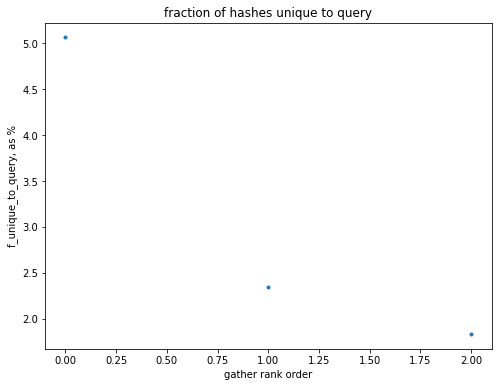

In [7]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')

pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

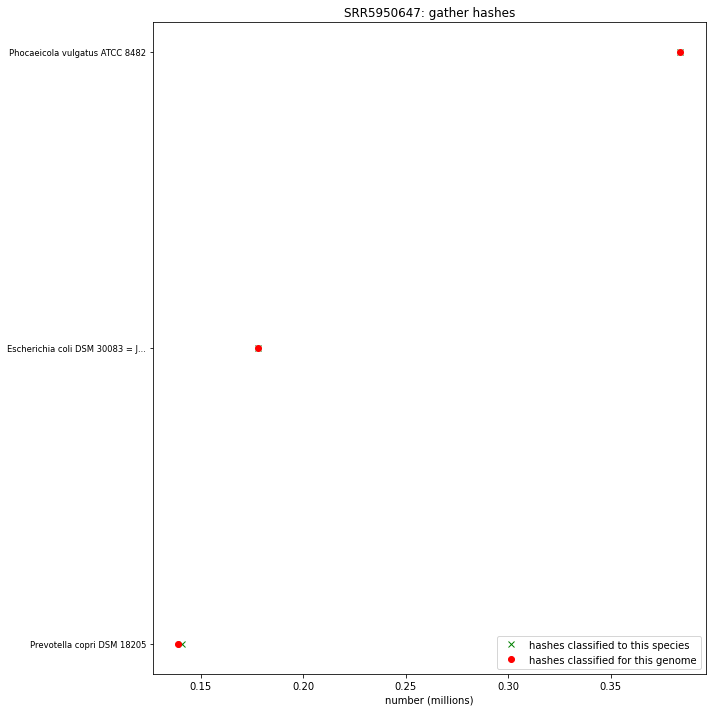

In [8]:
pylab.figure(num=None, figsize=(10, 10))

pylab.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

positions = list(gather_df.index)
labels = list(reversed(names_df.display_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('number (millions)')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes')
pylab.tight_layout()
